In [2]:
import math
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import and Prepare data

In [3]:
wine_df = pd.read_csv("wine_data.csv", sep=",")

wine_df = wine_df.reindex(
    np.random.permutation(wine_df.index))

In [4]:
wine_df.head()

,wine_id,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type_red,sugar_to_acidity_ratio
741,4553,7.1,0.3,0.2,15.4,0.1,46.0,198.0,1.0,3.1,0.5,8.8,5,0,2.2
359,2972,6.6,0.2,0.3,12.1,0.1,25.0,125.0,1.0,3.5,0.5,9.4,5,0,1.8
620,2179,6.8,0.3,0.3,2.3,0.0,16.0,85.0,1.0,3.2,0.6,12.4,6,0,0.3
2932,4244,7.6,0.2,0.4,1.1,0.0,38.0,143.0,1.0,2.9,0.4,11.4,5,0,0.1
881,3995,7.3,0.2,0.5,1.3,0.0,34.0,136.0,1.0,3.1,0.8,10.5,6,0,0.2


In [5]:
def preprocess_features(wine_df):
  # Make features df
  features = wine_df.copy()
  features = features.drop("wine_id", 1)
  features = features.drop("quality", 1)
  return features

def preprocess_targets(wine_df):
  # Make target df
  targets = wine_df.copy()
  targets = targets.loc[:, ["quality"]]
  return targets

### Create training and validation datasets

In [6]:
prop_for_training = 0.7
n_training = int(round(prop_for_training*len(wine_df),0))
n_val = len(wine_df) - n_training
print 'Size of training dataset: '
print n_training
print 'Size of validation dataset'
print n_val

Size of training dataset: 
4278
Size of validation dataset
1833


In [7]:
# Define training dataset.
training_examples = preprocess_features(wine_df.head(n_training))
training_targets = preprocess_targets(wine_df.head(n_training))

# Define validation dataset
validation_examples = preprocess_features(wine_df.tail(n_val))
validation_targets = preprocess_targets(wine_df.tail(n_val))

# Define full datasets (for getting predicted values)
examples = preprocess_features(wine_df)
targets = preprocess_targets(wine_df)

In [8]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

## Input function

In [9]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Load saved model

In [10]:
def get_model(features):
  # Load the DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.000001)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(features),
      hidden_units=[10, 10],
      optimizer=my_optimizer,
      model_dir='./models/wine_pred')

  return dnn_regressor

dnn_regressor = get_model(training_examples)

## Training function

In [11]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    reset,
    tf_object):

  periods = 100
  steps_per_period = steps / periods
  
  # Only save the last version of the model
  my_checkpointing_config = tf.estimator.RunConfig(
    keep_checkpoint_max = 1,       # Retain the 1 most recent checkpoints.
  )
  
  if reset:
    # Create a DNNRegressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=my_optimizer,
        model_dir='./models/wine_pred',
        config=my_checkpointing_config
    )
  else:
    dnn_regressor = tf_object
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["quality"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["quality"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["quality"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print "Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error
  print "Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error

  return dnn_regressor

## Train the model

Training model...
RMSE (on training data):
  period 00 : 0.78
  period 01 : 0.78
  period 02 : 0.78
  period 03 : 0.78
  period 04 : 0.78
  period 05 : 0.78
  period 06 : 0.78
  period 07 : 0.78
  period 08 : 0.78
  period 09 : 0.78
  period 10 : 0.78
  period 11 : 0.78
  period 12 : 0.78
  period 13 : 0.78
  period 14 : 0.78
  period 15 : 0.78
  period 16 : 0.78
  period 17 : 0.78
  period 18 : 0.78
  period 19 : 0.78
  period 20 : 0.78
  period 21 : 0.78
  period 22 : 0.78
  period 23 : 0.78
  period 24 : 0.78
  period 25 : 0.78
  period 26 : 0.78
  period 27 : 0.78
  period 28 : 0.78
  period 29 : 0.78
  period 30 : 0.78
  period 31 : 0.78
  period 32 : 0.78
  period 33 : 0.78
  period 34 : 0.78
  period 35 : 0.78
  period 36 : 0.78
  period 37 : 0.78
  period 38 : 0.78
  period 39 : 0.78
  period 40 : 0.78
  period 41 : 0.78
  period 42 : 0.78
  period 43 : 0.78
  period 44 : 0.78
  period 45 : 0.78
  period 46 : 0.78
  period 47 : 0.78
  period 48 : 0.78
  period 49 : 0.78
  perio

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Final RMSE (on training data):   0.78
Final RMSE (on validation data): 0.79


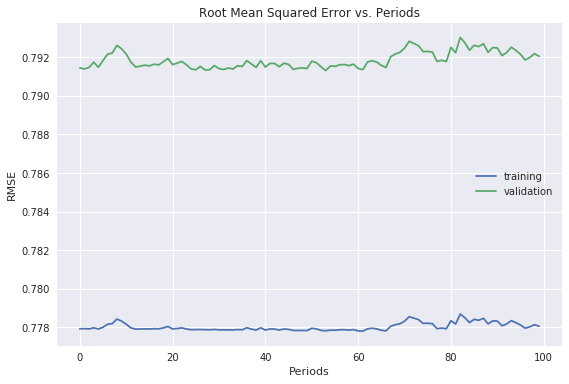

In [12]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.000001,
    steps=5000,
    batch_size=10,
    hidden_units=[10,10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    reset = False,
    tf_object = dnn_regressor)

## Get predicted values for all dataset

In [13]:
predict_training_input_fn = lambda: my_input_fn(examples, 
                                                  targets["quality"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  
predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])

## Plot actual vs. pred

(4.5, 7.5)

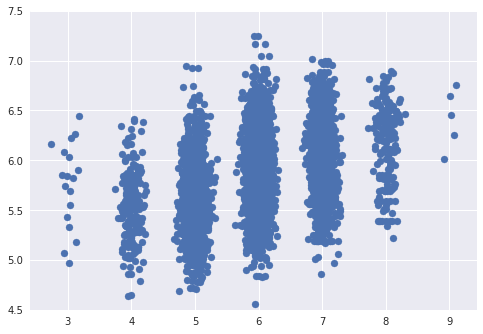

In [15]:
x = targets["quality"] + np.random.normal(0, 0.1, len(targets))
plt.scatter(x, predictions)
axes = plt.gca()
axes.set_ylim([4.5,7.5])

## Save model

In [67]:
v = tf.Variable(tf.constant(0))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, '/content/datalab/notebooks/models/tensorflow_model.ckpt')

## Write predicted values to BigQuery

In [82]:
results = wine_df.loc[:, ["wine_id"]]
results['predicted_quality'] = predictions

In [85]:
from google.cloud import bigquery
client = bigquery.Client(project='looker-action-hub')
dataset_ref = client.dataset('wine_data')

schema = [
    bigquery.SchemaField('wine_id', 'INTEGER', mode='REQUIRED'),
    bigquery.SchemaField('predicted_quality', 'FLOAT', mode='REQUIRED'),
]
table_ref = dataset_ref.table('predicted_quality')
table = bigquery.Table(table_ref, schema=schema)
# table = client.create_table(table)  # API request

In [86]:
client.create_rows(table, results.as_matrix())  # API request

[]